<a href="https://colab.research.google.com/github/kanishk16/Multimodal-Video-Classification/blob/master/Multimodal_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A brief about Challenge

* Problem Statement
  > Paper ref. - https://sci-hub.se/10.1145/2818346.2829994

  > To assign a single emotion label to the video clip from the eight universal emotions (Calm, Happy, Sad, Angry, Fearful, Disgust, Surprised and Neutral) on the given multimodal dataset. Use the first 20 actors for the training and rest(04) for testing.

* Approach

  > ConvNet (Spatial features) + LSTM (temporal features)
  
* Metrics
  > Confusion Matrix + Precision + Recall + F1 score

* References - 
1. The Ryerson Audio-Visual Database of Emotional Speech and Song(RAVDESS) Dataset - https://zenodo.org/record/1188976
2. https://discuss.pytorch.org/t/how-upload-sequence-of-image-on-video-classification/24865 
3. https://discuss.pytorch.org/t/solved-concatenate-time-distributed-cnn-with-lstm/15435
4. https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/#heading4

### Installing additional packages & importing necessary

In [1]:
%%capture
!apt-get install tree

!pip install -q torchinfo
!pip install -q torchmetrics
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
!pip install -q wandb

import os
import time
import io
import zipfile
import psutil
import humanize
import GPUtil
from collections import OrderedDict
import shutil

import cv2 as cv
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import wandb

import torch
from torchinfo import summary
from torchmetrics import Precision, Recall, F1, ConfusionMatrix, Accuracy
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import datasets, models, transforms

### CPU n GPU Footprint

In [2]:
def memory_report(cpu=True, gpu=True, verbose=False):
  ''' CPU n GPU footprint '''

  if cpu:
    print(f'---------- CPU ----------')
    if verbose:
      !lscpu

    print(f'RAM: {humanize.naturalsize(psutil.virtual_memory().available)}') 
    print(f'Cores x threads per core: {psutil.cpu_count()}')
    print(f'Utilisation: {psutil.virtual_memory().percent} %')    # ~ psutil.virtual_memory().used/psutil.virtual_memory().available*100

  if gpu:
    print(f'---------- GPU ----------')

    if verbose:
      !nvidia-smi

    # Method I: PyTorch leading the way
    gpu = torch.cuda.get_device_properties('cuda:0')
    gpus = GPUtil.getGPUs()[0]

    print(f'GPU Allocated: {gpu.name}')
    print(f'RAM: {gpus.memoryUsed/2**10 :.2f}/{gpu.total_memory/(2**30) :.2f} GB')
    # print(f'Utilisation: {(torch.cuda.memory_allocated()/2**20)/gpu.total_memory*100 :.2f} %')  # OUTPUT: ~ WRONG!!
    print(f'Utilisation: {gpus.memoryUtil*100 :.2f} %')
    
    # Method II: using an external package (GPUtil) 
    # gpus = GPUtil.getGPUs()
    # for id, gpu in enumerate(gpus):
    #   print(f'RAM: {gpu.memoryFree/1024 :.2f}/{gpu.memoryTotal/1024 :.2f}')
    #   print(f'Utilisation: {gpu.memoryUtil*100 :.2f}({gpu.memoryUsed/1024 :.2f})')

memory_report()

---------- CPU ----------
RAM: 12.7 GB
Cores x threads per core: 2
Utilisation: 7.0 %
---------- GPU ----------
GPU Allocated: Tesla K80
RAM: 0.00/11.17 GB
Utilisation: 0.03 %


### Setting Up the Dataset

> The format of the dataset provided to us is in the form of a zip file, we unzip and restructure into a train and test dir. After initial restructuring the dataset is stored:

```
* from: /content/audio_video/
                            ├── Actor_01 
                            ├── Actor_02 
                            ├── Actor_03 
                            ├── Actor_04
                                  ...

* to:/content/audio_video/train/
                                ├── angry
                                │   ├── Actor_01
                                │   ├── Actor_02
                                    ...
                                ├── calm
                                │   ├── Actor_01
                                │   ├── Actor_02
                                    ... 

```

Similarly for test dir ...

After initial observation, we realize that not only emotions have to be taken care of but even the actors can't be mixed up.

In [3]:
def initial_setup(mount_drive=True, initialise_wandb=True, reproduce=True, seed=2021):
  '''
  The Project Agnostic Setup: Mount Google Drive + Login to W&B + set seeds for reproducibility 
  '''
  # mount google drive
  if mount_drive and not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

  # setup W&B
  if initialise_wandb:
    wandb.login()

  # set seeds to reproduce the results
  if reproduce:
    np.random.seed(seed)
    torch.manual.seed(seed)

initial_setup(initialise_wandb=True, reproduce=False)

Mounted at /content/drive


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
def download_dataset(filename='/content/drive/MyDrive/HMI/audio-video.zip',
                     dirname='/content/audio_video/',
                     preprocessed=True):
  ''' 
  Recursively unzip the dataset to their respective dirs inside a dir passed as an arg
  '''
  
  if preprocessed:
    
    !unzip -q /content/drive/MyDrive/HMI_backup/audio_video.zip
    shutil.move('/content/content/audio_video', '/content/audio_video')
    shutil.rmtree('/content/content')

    train_df = pd.read_csv('/content/drive/MyDrive/HMI_backup/train.csv', index_col=0)
    test_df = pd.read_csv('/content/drive/MyDrive/HMI_backup/test.csv', index_col=0)
    
    return train_df, test_df

  else:
    with zipfile.ZipFile(filename) as zip_files:
      for zip_file in tqdm(zip_files.namelist()[1:]):
        data = io.BytesIO(zip_files.read(zip_file))
        _zip_file = zipfile.ZipFile(data)
        _zip_file.extractall(dirname)

train_df, test_df = download_dataset(preprocessed=True)

In [ ]:
# dir structure
!tree -d /content/audio_video/

In [5]:
# defining train and test dir paths
TRAIN_DIR = '/content/audio_video/train'
TEST_DIR = '/content/audio_video/test'

idx2class = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
class2idx = {cls:idx for idx, cls in enumerate(idx2class)}

In [6]:
def get_emotion(file):
  ''' 
  returns the emotion based upon the filename
  '''
  if file.startswith('02-01-01'):
    return f'neutral'
  elif file.startswith('02-01-02'):
    return f'calm'
  elif file.startswith('02-01-03'):
    return f'happy'
  elif file.startswith('02-01-04'):
    return f'sad'
  elif file.startswith('02-01-05'):
    return f'angry'
  elif file.startswith('02-01-06'):
    return f'fearful'
  elif file.startswith('02-01-07'):
    return f'disgust'
  elif file.startswith('02-01-08'):
    return f'surprised'

In [ ]:
def structure_dir(src='/content/audio_video', n_samples=20):
  '''
    returns a reorganized directory structure by splitting the dataset into TRAIN/TEST and includes only videos:
    TRAIN (0-20 actors)- /audio_video/train
    TEST (21-24) - /audio_video/test
  '''
  dirs = os.listdir(src)
  dirs.sort()
  train_dirs = dirs[:n_samples]
  test_dirs = dirs[n_samples:]

  if not os.path.exists(TRAIN_DIR):
    for cls in idx2class:
      for dir in train_dirs:
        os.makedirs(f'{TRAIN_DIR}/{cls}/{dir}', exist_ok=True)

  if not os.path.exists(TEST_DIR):
    for cls in idx2class:
      for dir in test_dirs:
        os.makedirs(f'{TEST_DIR}/{cls}/{dir}', exist_ok=True)

  for dir in tqdm(train_dirs):
    for file in os.listdir(f'{src}/{dir}'):
      dst = f'{TRAIN_DIR}/{get_emotion(file)}/{dir}'
      if 'None' not in dst and os.path.isfile(f'{src}/{dir}/{file}'):
        shutil.move(f'{src}/{dir}/{file}', f'{dst}/{file}')
    shutil.rmtree(f'{src}/{dir}')
    
  for dir in tqdm(test_dirs):
    for file in os.listdir(f'{src}/{dir}'):
      dst = f'{TEST_DIR}/{get_emotion(file)}/{dir}'
      if 'None' not in dst and os.path.isfile(f'{src}/{dir}/{file}'):
        shutil.move(f'{src}/{dir}/{file}', f'{dst}/{file}')
    shutil.rmtree(f'{src}/{dir}')

structure_dir()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
!tree -d /content/audio_video/train/

### Feature Extraction

Videos are just sequences of images (frames). Usually there exists multiple frames in a second. Moreover, most of these frames don't comprise information that is significantly different. Also, the frames which that are redundant are usually the successive ones. Hence, we extract `n_frames` from each video and store them in their respective dir. Furthermore, it is a trick to reduce the complexity.


In [7]:
def get_frames(src, n_frames=16):
  '''
  returns a list of evenly spaced n_frames extracted from each video 
  '''
  frames_list = []
  video = cv.VideoCapture(src)

  # total frames
  vframes = int(video.get(cv.CAP_PROP_FRAME_COUNT)) 

  # frames to be selected
  frames_idx = np.linspace(0, vframes-1, n_frames+1, dtype=np.int16)
  
  for f in range(vframes):
    (grabbed, frame) = video.read()

    if not grabbed:
      break

    if f in frames_idx:
      frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
      frames_list.append(frame)

  video.release()
  return frames_list
 

def store_frames(frames_list, dst):
  '''
  stores a set of imgs. from the extracted n_frames of each video and
  returns a list of frames with all the details
  '''
  video_name = os.path.basename(dst)
  # print('video_name:',video_name)         # 02-01-05-01-01-02-09
  
  dst = os.path.dirname(dst)
  # print('dst:',dst)                       # /content/audio_video/train/angry/Actor_12

  emotion = get_emotion(video_name)

  actor = os.path.basename(dst)

  frames_dict = []

  for ii, frame in enumerate(frames_list):
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    
    path2img = f'{dst}/{video_name}_frame_{str(ii)}.jpg'
    # print('path2img:',path2img)           # /content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_0.jpg

    dict4df = {'path2img':path2img, 'actor':actor, 'emotion':emotion, 'target':class2idx[emotion]}
    
    frames_dict.append(dict4df)
    cv.imwrite(path2img, frame)
  
  return frames_dict


In [ ]:
def create_dataset(avtrain_df, avtest_df, n_frames=16):
  '''
  extract n_frames(imgs.) from each video and store them as jpg imgs.
  '''
  emotions = os.listdir(TRAIN_DIR)

  for emotion in tqdm(emotions):
    for actor in tqdm(os.scandir(f'{TRAIN_DIR}/{emotion}')):
      for file in os.listdir(f'{TRAIN_DIR}/{emotion}/{actor.name}'):
        filename = f'{TRAIN_DIR}/{emotion}/{actor.name}/{file}'
        frames = get_frames(filename)
        train_frames = store_frames(frames, os.path.splitext(filename)[0])
        avtrain_df = avtrain_df.append(train_frames)
        os.remove(filename)

  emotions = os.listdir(TEST_DIR)

  for emotion in tqdm(emotions):
    for actor in tqdm(os.scandir(f'{TEST_DIR}/{emotion}')):
      for file in os.listdir(f'{TEST_DIR}/{emotion}/{actor.name}'):
        filename = f'{TEST_DIR}/{emotion}/{actor.name}/{file}'
        frames = get_frames(filename)
        test_frames = store_frames(frames, os.path.splitext(filename)[0])
        avtest_df = avtest_df.append(test_frames)
        os.remove(filename)

  return avtrain_df, avtest_df

train_df = pd.DataFrame(columns=['path2img', 'target', 'emotion'])
test_df = pd.DataFrame(columns=['path2img', 'target', 'emotion'])

train_df, test_df = create_dataset(avtrain_df=train_df, avtest_df=test_df)


### Minimal EDA 

In [8]:
# sanity check
print(train_df.shape)

print(test_df.shape)

# save as csv file
# train_df.to_csv('/content/drive/MyDrive/HMI_backup/train.csv')

# test_df.to_csv('/content/drive/MyDrive/HMI_backup/test.csv')

(19920, 4)
(4080, 4)


emotion
angry        2656
calm         2656
disgust      2656
fearful      2656
happy        2656
neutral      1328
sad          2656
surprised    2656
Name: target, dtype: int64


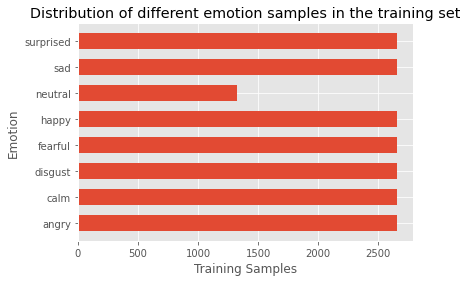

In [ ]:
def plot_distribution(df=train_df):
  ''' plots a bar chart indication the distribution of emotions'''

  plt.style.use('ggplot')

  fig, ax = plt.subplots()

  samples = df.groupby(['emotion'])['target'].agg('count')
  print(samples)

  data = [sample for sample in samples]
  labels = sorted(df['emotion'].unique())
  ax.set_title(f"Distribution of different emotion samples in the training set")
  
  ax.barh(labels, data, height=0.6)
  ax.set_xlabel('Training Samples')
  ax.set_ylabel('Emotion')
  ax.set_yticklabels(labels)
      
  plt.show()

plot_distribution()

The above bar plot shows that the dataset is quite balanced. This helps us to estabilish that even Classification as an evaluation metric would be suitable. Also, we are relieved of handling the data imbalance. 

In [9]:
def train_val_split(df=train_df, split=0.2):
  ''' splits the training set into 80:20 (default) and returns a val_df '''

  actors = df['actor'].unique().tolist()
  actors.sort()

  val_size = int(split*len(actors))
  # print(val_size)

  val_actors = actors[-val_size:]
  print(val_actors)

  val_df = df.loc[df['actor'].isin(val_actors)]

  return val_df

val_df = train_val_split()
print(val_df.shape)

['Actor_17', 'Actor_18', 'Actor_19', 'Actor_20']
(3960, 4)


In [ ]:
pd.set_option('display.max_colwidth', None)

train_df.head()

,path2img,target,emotion,actor
0,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_0.jpg,4,angry,Actor_12
1,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_1.jpg,4,angry,Actor_12
2,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_2.jpg,4,angry,Actor_12
3,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_3.jpg,4,angry,Actor_12
4,/content/audio_video/train/angry/Actor_12/02-01-05-01-01-02-12_frame_4.jpg,4,angry,Actor_12


In [ ]:
val_df.head()

,path2img,target,emotion,actor
0,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_0.jpg,4,angry,Actor_18
1,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_1.jpg,4,angry,Actor_18
2,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_2.jpg,4,angry,Actor_18
3,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_3.jpg,4,angry,Actor_18
4,/content/audio_video/train/angry/Actor_18/02-01-05-01-01-02-18_frame_4.jpg,4,angry,Actor_18


In [ ]:
test_df.head()

,path2img,target,emotion,actor
0,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_0.jpg,4,angry,Actor_24
1,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_1.jpg,4,angry,Actor_24
2,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_2.jpg,4,angry,Actor_24
3,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_3.jpg,4,angry,Actor_24
4,/content/audio_video/test/angry/Actor_24/02-01-05-01-01-02-24_frame_4.jpg,4,angry,Actor_24


### Data Pipeline

In [10]:
# transforms for the dataset
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((224,224)),                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])                         
                                   ])

After observing the dataset, we could conclude that not only different emotions need to be classified but also the actors shouldn't be mixed up. Hence, we need to calculate valid frames per emotion per actor. The Sampler ensures that only valid frames are selected from the complete dataset. 

In [11]:
def get_frame_idx(df=train_df):
  '''
  returns a list of end frame indices for each emotion n actor   
  '''
  frame_idx = [0]

  idx = df.groupby(['emotion', 'actor'])['path2img'].count().values
  idx = idx.tolist()

  frame_idx.extend(idx)

  return torch.cumsum(torch.tensor(frame_idx), dim=0)


class AVSampler(Sampler):
  '''Custom Sampling Class for selection of valid frames'''
  def __init__(self, frame_idx, n_frames):
    frames = []
    for i in range(len(frame_idx)-1):
      start = frame_idx[i] 
      end = frame_idx[i+1] - n_frames
      frames.append(torch.arange(start, end))
    frames = torch.cat(frames)
    self.frames = frames

  def __iter__(self):
    frames = self.frames[torch.randperm(len(self.frames))]
    return iter(frames.tolist())
    
  def __len__(self):
    return len(self.frames)


class AVDataset(Dataset):
  ''' Custom Dataset Class '''
  def __init__(self, length, df=train_df, transform=train_transforms, n_frames=16):
    self.length = length
    self.df = df
    self.transform = transform
    self.n_frames = n_frames

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    ''' returns a data sample(img.) after applying transforms & the associated target(y_label) for a key(idx/index)'''
    frames_start = idx
    frames_end = idx + self.n_frames
    idxs = list(range(frames_start, frames_end))

    imgs = []
    for i in idxs:
      img_path = self.df.iloc[i]['path2img'] 
      img = cv.imread(img_path)
      img = self.transform(img)
      imgs.append(img)

    imgs = torch.stack(imgs)
    y_label = torch.tensor(self.df.iloc[frames_start]['target'], dtype=torch.long)
    
    return (imgs, y_label)


#### Speeding Up the Training Pipeline (Experiments)

1. Batch Size: 64  |  num_workers: 0  |  pin_memory: False
  > Time (per batch): 22.14s (batch 0) 20.76s (batch 5)\
  CPU Utilisation:  19.6 %  | GPU Utilisation: 4.57 -> 9.71 -> 64.79 

2. Batch Size: 64  |  num_workers: 1  |  pin_memory: False
  > Time (per batch): 22.82s (batch 0) 20.89s (batch 5)\
  CPU Utilisation:  19.9 %  | GPU Utilisation: 64.83 %

3. Batch Size: 64  |  num_workers: 2  |  pin_memory: False
  > Time (per batch): 39.08 $\pm$ 3s (batch 0) 2.25s (batch 5)\
  CPU Utilisation:  24.5 %  | GPU Utilisation: 64.83 % 

4. (R) Batch Size: 64  |  num_workers: 2  |  pin_memory: True 
  > Time (per batch): 37.51 $\pm$ 3s (batch 0) 1.86s (batch 5)\
  Time (per epoch): 1h 35m 16s\
  CPU Utilisation:  24.8 - 29.3 %  | GPU Utilisation: 64.86 % 

5. Batch Size: 64  |  num_workers: 4  |  pin_memory: True
  > Time (per batch): 71.55 $\pm$ s (batch 0) 1.87s (batch 5)\
  Time (per epoch): ~ 1h 45m\
  CPU Utilisation:  51.3 %  | GPU Utilisation: 64.88 % 

6. Batch Size: 64  |  num_workers: 8  |  pin_memory: True
  > Time (per batch): 37.51s (batch 0) s (batch 5)\
  CPU Utilisation:  crash %  | GPU Utilisation: 64.86 % 

In [12]:
# HYPERPARAMS
hyperparams = {
    'BATCH_SIZE' : 64,
    'EPOCHS' : 10,
    'LR' : 1e-3,
    'PATIENCE' : 3,
    'FACTOR' : 0.1
}

train_frame_idx = get_frame_idx(df=train_df)
val_frame_idx = get_frame_idx(df=val_df)
test_frame_idx = get_frame_idx(df=test_df)

train_sampler = AVSampler(train_frame_idx, n_frames=16)
val_sampler = AVSampler(val_frame_idx, n_frames=16)
test_sampler = AVSampler(test_frame_idx, n_frames=16)

train_data = AVDataset(length=len(train_sampler), df=train_df, transform=train_transforms)
val_data = AVDataset(length=len(val_sampler), df=val_df, transform=test_transforms)
test_data = AVDataset(length=len(test_sampler), df=test_df, transform=test_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=hyperparams['BATCH_SIZE'], sampler=train_sampler, num_workers=2, pin_memory=True, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=hyperparams['BATCH_SIZE'], sampler=val_sampler, num_workers=2, pin_memory=True, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=hyperparams['BATCH_SIZE'], sampler=test_sampler, num_workers=2, pin_memory=True, shuffle=False)

#### Approach, Model Architecture and Training

Different approaches are available to solve the problem ranging from hacky schemes (Single frame CNN) to 3D CNNs. Since the video clips were devoid of background features, we need to capitalize on the sequence. ConvNet combined with an LSTM would be a good choice as the ConvNet would be able to extract spatial features and the LSTM would extract the temporal features. 

In [13]:
class ResNet18_LSTM(nn.Module):
  '''
  returns a pretrained ConvNet (resnet18) + LSTM model
  '''
  def __init__(self, n_class, pretrained=True, freeze=True):
    super(ResNet18_LSTM, self).__init__()
    # pretrained resnet18
    self.pretrainedmodel = models.resnet18(pretrained=pretrained)

    if freeze:
      for param in self.pretrainedmodel.parameters():
        param.requires_grad = False

    # attach a linear classifier
    self.pretrainedmodel.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(self.pretrainedmodel.fc.in_features,256)),
                          ]))
    
    # pass the features into an LSTM
    self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True)
  
    # linear classifier 
    # self.fc2 = nn.Linear(in_features=128, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=n_class)


  def yolomod(self, model, brief=True):
    ''' yolomod: you only look once at the model description'''
    if brief:
      print(summary(model))
    else:
      print(model)


  def forward(self, frames, vectorized=True):
    bs, ts, c, h, w = frames.shape

    if vectorized:
      
      # print('frames.view(bs*ts, c, h, w):', frames.view(bs*ts, c, h, w).shape)    # OUTPUT: [512, 3, 224, 224]
      x = self.pretrainedmodel(frames.view(bs*ts, c, h, w))                         
      # print('features extracted:', x.shape)                                       # OUTPUT: [512, 256]      

      # print('x.view(bs, ts, -1):', x.view(bs, ts, -1).shape)                      # OUTPUT: [32, 16, 256]
      _output, (hn,cn) = self.lstm(x.view(bs, ts, -1))
      # print('_output:', _output.shape)                                            # OUTPUT: [32, 16, 128]  

      # print('_output:', _output[:, -1, :].shape)                                  # OUTPUT: [32, 128] using only the last states of lstm
      output = self.fc2(_output[:, -1, :])
      # print('output:', output.shape)                                              # OUTPUT: [32, 8]
      
      return output    

    else:
      final_state = None
      for t in range(ts):
        with torch.no_grad():
          x = self.pretrainedmodel(frames[:, t, :, :, :])
          
          # print('features extracted:', x.shape)                                     # OUTPUT: [32, 256]
          # print('Input2LSTM :', x.unsqueeze(0).shape)                               # OUTPUT: [1, 32, 256]
          # print('Input2LSTM :', x.unsqueeze(1).shape)                               # OUTPUT: [32, 1, 256]

        _output, final_state = self.lstm(x.unsqueeze(1), final_state)
        # print('_output:', _output.shape)                                            # OUTPUT: [1, 32, 128] [32, 1, 128] 

      # print('_output[-1, :, :]: ', _output.squeeze().shape)                         # OUTPUT: [32, 128]
      # print('self.fc2(output[-1, :, :]): ', self.fc2(_output[-1, :, :]).shape)

      # output = F.relu(self.fc2(_output[:, -1]))

      # print('F.relu(self.fc2(_output[-1, :, :])): ', output.shape)
      
      output = self.fc2(_output.squeeze())
      # print('output:', output.shape)                      # OUTPUT: [32, 8]
      
      return output    

model = ResNet18_LSTM(n_class=8)
# model.yolomod(model, brief=False)

# initialize device as cuda if on GPU...
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print(f'on {device}!')
  model.to(device)
else:
  device = torch.device("cpu")
  print(f'on {device}!')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

on cuda:0!


In [14]:
memory_report()

---------- CPU ----------
RAM: 11.5 GB
Cores x threads per core: 2
Utilisation: 15.5 %
---------- GPU ----------
GPU Allocated: Tesla K80
RAM: 0.51/11.17 GB
Utilisation: 4.57 %


In [14]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=hyperparams['LR'])

# specify scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=hyperparams['PATIENCE'],
                                                 factor=hyperparams['FACTOR'], verbose=True)

In [15]:
def save_checkpoint(epoch, model_state_dict, optim_state_dict, losses, accuracy,
                    precision, recall, f1_score, filepath='/content/drive/MyDrive/HMI_backup/mmvc.pt'):
  '''
  Creates a checkpoint to restore the STATUS-QUO
  '''
  print('Saving Model ...')

  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model_state_dict,
      'optimizer_state_dict': optim_state_dict,
      'scheduler_state_dict': scheduler_state_dict,
      'losses': losses,
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1_score
  }

  torch.save(checkpoint, filepath)

def load_model_checkpoint(filepath, model):
  '''
  Loads the saved model checkpoint dict
  '''
  checkpoint = torch.load(filepath)

  print(f'Restoring the model state to epoch{checkpoint['epoch']}')

  # model = ()
  model.load_state_dict(checkpoint['model_state_dict'], strict=False)
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'], strict=False)

def load_inference_checkpoint(filepath):
  '''
  Loads the saved checkpoint dict
  '''
  checkpoint = torch.load(filepath)

  print(f'Restoring the losses state to epoch{checkpoint['epoch']}')
  train_losses, val_losses, auc_score = checkpoint['train_losses'], checkpoint['val_losses'], checkpoint['auc_score']
  return train_losses, val_losses, auc_score


In [19]:
def track_experiments(group, job_type, project='multimodal video classification', config=hyperparams):
  ''' Launch Experiment Tracking '''
  
  # initialize run
  run = wandb.init(group=group, job_type=job_type, project=project, entity='kanish2k', config=config)
  
  return run

run = track_experiments(group='exp_1', job_type='epochs_2')

In [ ]:
wandb.init(project='multimodal video classification', entity='kanish2k')

wandb: Currently logged in as: kanish2k (use `wandb login --relogin` to force relogin)


In [17]:
# initialize evaluation metrics
losses = {
    'train': [],
    'val': []
}

train_precision = Precision()
val_precision = Precision()
precision = {
    'train': [],
    'val': []
}


train_recall = Recall()
val_recall = Recall()
recall ={
    'train': [],
    'val': []
}


train_f1 = F1()
val_f1 = F1()
f1_score = {
    'train': [],
    'val': []
}

train_accuracy = Accuracy()
val_accuracy = Accuracy()
accuracy = {
    'train': [],
    'val': []
}


In [ ]:
%%wandb
val_loss_min = np.Inf

# log_interval = 100

for epoch in range(1, hyperparams['EPOCHS']+1):
  
  print(f"---------- Epoch: {epoch}/{hyperparams['EPOCHS']} ----------")
  train_loss = 0.0

  train_progress_bar = tqdm(train_loader)

  model.train()

  for batch_idx, (images, labels) in enumerate(train_progress_bar):

    # print('images: ', images.shape, 'labels: ', labels.shape)                   # OUTPUT: imgs: [32, 16, 3, 224, 224] labels: [32]
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    scores = model(images)

    loss = criterion(scores, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()

    preds = F.softmax(scores, dim=1).cpu()
    # print('preds:', preds.shape, 'on GPU:', preds.is_cuda)                      # OUTPUT: [32, 8] False

    targets = labels.cpu()                                                      
    # print('targets:', targets.shape, 'on GPU:', targets.is_cuda)                # OUTPUT: [32] False

    # calc. metrics
    _train_precision = train_precision(preds, targets)
    _train_recall = train_recall(preds, targets)
    _train_f1 = train_f1(preds, targets)
    _train_accuracy = train_accuracy(preds, targets)

    train_progress_bar.set_postfix(f1=_train_f1.item())

  else:

    with torch.no_grad():
      model.eval()

      val_loss = 0.0

      val_progress_bar = tqdm(val_loader)

      for images, labels in enumerate(val_progress_bar):
        
        images, labels = images.to(device), labels.to(device)

        scores = model(images)

        loss = criterion(scores, labels)
        
        val_loss += loss.item()

        preds = F.softmax(scores, dim=1).cpu()
        targets = labels.cpu()

        _val_precision = val_precision(preds, targets)
        _val_recall = val_recall(preds, targets)
        _val_f1 = val_f1(preds, targets)
        _val_accuracy = val_accuracy(preds, targets)

        val_progress_bar.set_postfix(f1=_val_f1.item())

    train_loss = train_loss/len(train_loader)
    losses['train'].append(train_loss)

    val_loss = val_loss/len(val_loader) 
    losses['val'].append(val_loss)

    precision['train'].append(train_precision.compute().item())
    train_precision.reset()
    precision['val'].append(val_precision.compute().item())
    val_precision.reset()

    recall['train'].append(train_recall.compute().item())
    train_recall.reset()
    recall['val'].append(val_recall.compute().item())
    val_recall.reset()

    f1_score['train'].append(train_f1.compute().item())
    train_f1.reset()
    f1_score['val'].append(val_f1.compute().item())
    val_f1.reset()
 
    accuracy['train'].append(train_accuracy.compute().item())
    train_accuracy.reset()
    accuracy['val'].append(val_accuracy.compute().item())
    val_accuracy.reset()

    print(f'Loss: Train={train_loss:.6f}, Val={val_loss:.6f}')
    print(f"Precision: Train={precision['train'][epoch]:.3f}, Val={precision['val'][epoch]:.3f}")
    print(f"Recall:    Train={recall['train'][epoch]:.3f},    Val={recall['val'][epoch]:.3f}")
    print(f"F1_score:  Train={f1_score['train'][epoch]:.3f},  Val={f1_score['val'][epoch]:.3f}")
    print(f"Accuracy:  Train={accuracy['train'][epoch]:.3f},  Val={accuracy['val'][epoch]:.3f}")

    wandb.log({'Epoch':epoch, 'Train Loss': train_loss, 'Val Loss': val_loss, 
               'Train Accuracy': accuracy['train'][epoch], 'Val Accuracy': accuracy['val'][epoch],
               'Train F1_score': f1_score['train'][epoch], 'Val F1_score': f1_score['val'][epoch]})

    scheduler.step(val_loss)

    if val_loss <= val_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
      save_checkpoint(epoch, model.state_dict(), optim.state_dict(), losses, precision, recall, f1_score, accuracy, '/content/mvc.pth')
      val_loss_min = val_loss


---------- Epoch: 1/10 ----------


  0%|          | 0/272 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
  # %%wandb
  # best_val_f1 = -np.Inf
val_loss_min = np.Inf

log_interval = 100

for epoch in range(1, EPOCHS+1):
  
  print(f'---------- Epoch: {epoch}/{EPOCHS} ---------- ')
  train_loss, manual_train_accuracy = 0.0, 0.0

  model.train()

  start_time = time.time()

  for batch_idx, (images, labels) in enumerate(train_loader):

    # print('images: ', images.shape, 'labels: ', labels.shape)                   # OUTPUT: imgs: [32, 16, 3, 224, 224] labels: [32]
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    scores = model(images)

    loss = criterion(scores, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()

    preds = F.softmax(scores, dim=1)
    print('preds:', preds.shape)                                                # OUTPUT: [32, 8]

    print('labels:', labels.shape)                                              # OUTPUT: [32, 8]
    # targets = labels.view(-1, 1)
    print('targets:', targets.shape)

    # calc. metrics
    _train_precision = train_precision(preds, labels)
    _train_recall = train_precision(preds, labels)
    _train_f1 = train_f1(preds, labels)
    _train_accuracy = train_accuracy(preds, labels)

    _, train_top_class = preds.topk(1, dim=1)
    print('train_top_class: ', train_top_class.shape)
    print('*train_top_class: ', *train_top_class.shape)

    train_equals = train_top_class == labels.view(*train_top_class.shape)
  
    manual_train_accuracy = torch.mean(train_equals.type(torch.FloatTensor))

    stop_time = time.time()

    if batch_idx % log_interval == 0 or batch_idx == 0:
      print(f'Batch: {batch_idx} || Time: {stop_time - start_time :.2f}s') 
      print(f'Train Accuracy: {manual_train_accuracy:.6f}')
      print(f'Train Accuracy (torchmetrics): {_train_accuracy:.6f}')
      break

    start_time = stop_time 

  else:

    with torch.no_grad():
      model.eval()

      val_loss, val_accuracy = 0.0, 0.0

      for images, labels in val_loader:
        
        images, labels = images.to(device), labels.to(device)

        scores = model(images)

        loss = criterion(scores, labels)
        
        val_loss += loss.item()

        val_predictions = F.softmax(scores, dim=1) 

        _val_precision = val_precision(val_predictions, labels)
        _train_recall = train_precision(val_predictions, labels)
        _val_f1 = val_f1(val_predictions, labels)

        _, val_top_class = val_predictions.topk(1, dim=1)
      
        # calc. correct classes (Compare top_k and labels)
        # val_equals = val_top_class == labels.view(*val_top_class.shape)
      
        # calc. accuracy
        # val_accuracy = torch.mean(val_equals.type(torch.FloatTensor))

    train_loss = train_loss/len(train_loader)
    losses['train_losses'].append(train_loss)

    val_loss = val_loss/len(val_loader) 
    losses['val_losses'].append(val_loss)

    precision['train'].append(train_precision.compute().item())
    precision['val'].append(val_precision.compute().item())

    recall['train'].append(train_recall.compute().item())
    recall['val'].append(val_recall.compute().item())

    f1valin'].append(train_f1.compute().item())
    f1['val'].append(val_f1.compute().item())

    print(f'Train Accuracy: {train_accuracy:.6f} || Validation Accuracy: {val_accuracy:.6f}')
    print(f'Train Loss: {train_loss:.6f} || Val Loss: {val_loss:.6f}')
    wandb.log({'Epoch':epoch, 'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Accuracy': train_accuracy, 
               'Validation Accuracy': val_accuracy})

    scheduler.step(val_loss)

    # save model if validation loss has decreased
    if val_loss <= val_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
      torch.save(model.state_dict(), '/content/mvc.pth')
      val_loss_min = val_loss


---------- Epoch: 1/1 ---------- 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Batch: 0 || Time: 75.65s
Train Accuracy: 0.140625
Batch: 10 || Time: 1.85s
Train Accuracy: 0.171875
Batch: 20 || Time: 68.79s
Train Accuracy: 0.250000
Batch: 30 || Time: 1.87s
Train Accuracy: 0.156250
Batch: 40 || Time: 69.68s
Train Accuracy: 0.093750
Batch: 50 || Time: 1.84s
Train Accuracy: 0.281250
Batch: 60 || Time: 68.30s
Train Accuracy: 0.250000
Batch: 70 || Time: 1.87s
Train Accuracy: 0.234375
Batch: 80 || Time: 65.96s
Train Accuracy: 0.281250
Batch: 90 || Time: 1.84s
Train Accuracy: 0.312500
Batch: 100 || Time: 65.95s
Train Accuracy: 0.343750
Batch: 110 || Time: 1.87s
Train Accuracy: 0.421875
Batch: 120 || Time: 62.23s
Train Accuracy: 0.546875
Batch: 130 || Time: 1.84s
Train Accuracy: 0.468750
Batch: 140 || Time: 58.97s
Train Accuracy: 0.343750
Batch: 150 || Time: 1.86s
Train Accuracy: 0.484375
Batch: 160 || Time: 56.84s
Train Accuracy: 0.453125
Batch: 170 || Time: 1.85s
Train Accuracy: 0.437500
Batch: 180 || Time: 55.97s
Train Accuracy: 0.359375
Batch: 190 || Time: 1.88s
Train 